In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

In [7]:
!pip list

Package                 Version
----------------------- ------------
absl-py                 2.3.0
accelerate              1.7.0
addict                  2.4.0
asttokens               3.0.0
bitsandbytes            0.46.0
certifi                 2025.4.26
cfgv                    3.4.0
charset-normalizer      3.4.2
colorama                0.4.6
comm                    0.2.2
contourpy               1.3.2
cycler                  0.12.1
debugpy                 1.8.14
decorator               5.2.1
distlib                 0.3.9
einops                  0.8.1
exceptiongroup          1.3.0
executing               2.2.0
facexlib                0.3.0
filelock                3.13.1
filterpy                1.4.5
fonttools               4.58.1
fsspec                  2024.6.1
ftfy                    6.3.1
future                  1.0.0
grpcio                  1.72.1
huggingface-hub         0.32.4
icecream                2.1.4
identify                2.6.12
idna                    3.10
imageio          

In [6]:
# Sprawdzenie GPU
print("CUDA dostępna:", torch.cuda.is_available())
print("Liczba GPU:", torch.cuda.device_count())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak GPU")

CUDA dostępna: True
Liczba GPU: 1
Nazwa GPU: NVIDIA GeForce RTX 3090


In [9]:
csv_path = Path("D:/Programowanie/Datasets/koniq10k/koniq10k_distributions_sets.csv")
df = pd.read_csv(csv_path)

In [10]:
df.head()
df.columns

Index(['image_name', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_total', 'MOS', 'SD',
       'set'],
      dtype='object')

In [11]:
images_path = Path("D:/Programowanie/Datasets/koniq10k/512x384")
df["path"] = df["image_name"].apply(lambda x: images_path / x)

In [13]:
df["MOS"]

0        77.383621
1        68.728571
2        78.628571
3        77.243750
4        75.112500
           ...    
10068    70.020089
10069    79.337838
10070    78.092437
10071    68.095133
10072    67.219027
Name: MOS, Length: 10073, dtype: float64

In [15]:
df.describe(include='all')

,image_name,c1,c2,c3,c4,c5,c_total,MOS,SD,set,path
count,10073,10073.000000,10073.000000,10073.000000,10073.000000,10073.000000,10073.000000,10073.000000,10073.000000,10073,10073
unique,10073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10073
top,10004473376.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,training,D:\Programowanie\Datasets\koniq10k\512x384\100...
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7058,1
mean,NaN,0.022814,0.165164,0.455935,0.339394,0.016694,107.034051,58.729617,0.574666,NaN,NaN
std,NaN,0.076469,0.210293,0.181751,0.245790,0.030151,7.986917,15.432433,0.065992,NaN,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,93.000000,3.911765,0.296230,NaN,NaN
25%,NaN,0.000000,0.017241,0.321101,0.096154,0.000000,103.000000,49.247768,0.531602,NaN,NaN
50%,NaN,0.000000,0.058252,0.476636,0.330357,0.000000,106.000000,62.354369,0.568305,NaN,NaN
75%,NaN,0.009434,0.254545,0.603774,0.557692,0.019608,109.000000,70.712500,0.611210,NaN,NaN


In [36]:
from torch.utils.data import Dataset

IMG_SIZE = (224, 224)

# Transformacje z augmentacją
aug_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

class KonIQDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']               # pełna ścieżka do obrazu
        label = row['MOS']               # etykieta (jakość)
        
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

In [37]:
dataset = KonIQDataset(df, transform=aug_transform)
image, label = dataset[0]  # wczytanie 1. obrazu

In [38]:
dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor(77.3836))

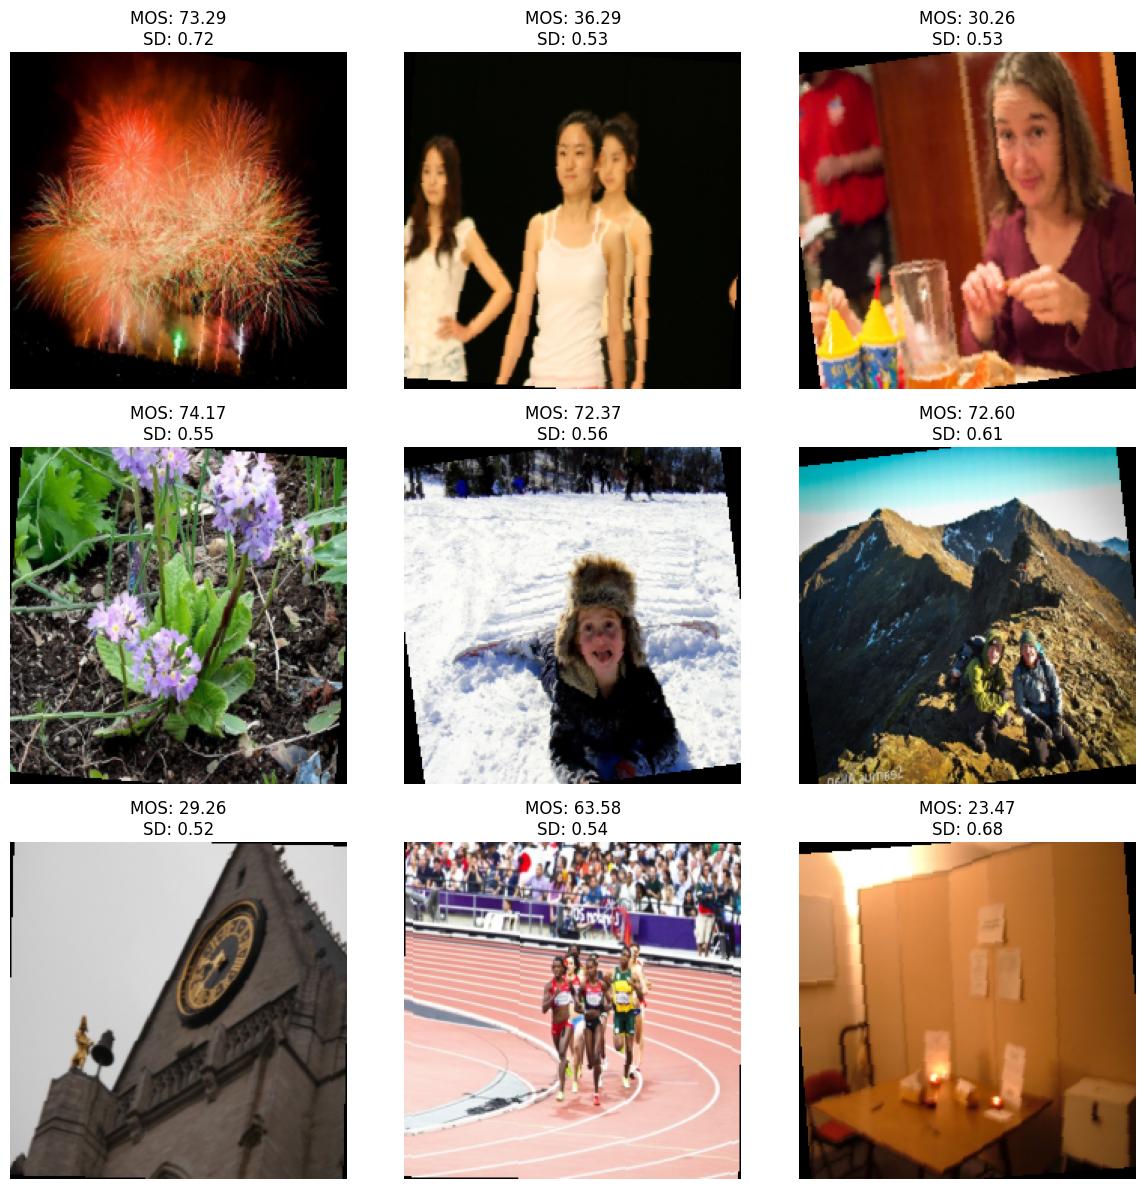

In [39]:
import random

plt.figure(figsize=(12, 12))
indices = random.sample(range(len(dataset)), 9)

for i, idx in enumerate(indices):
    image, mos = dataset[idx]
    sd = dataset.df.iloc[idx]["SD"]
    
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(image.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
    ax.set_title(f"MOS: {mos:.2f}\nSD: {sd:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

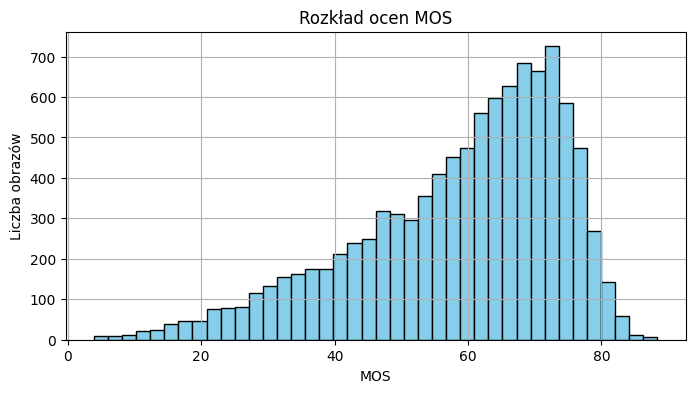

In [40]:
plt.figure(figsize=(8, 4))
df["MOS"].hist(bins=40, color="skyblue", edgecolor="black")
plt.title("Rozkład ocen MOS")
plt.xlabel("MOS")
plt.ylabel("Liczba obrazów")
plt.grid(True)
plt.show()

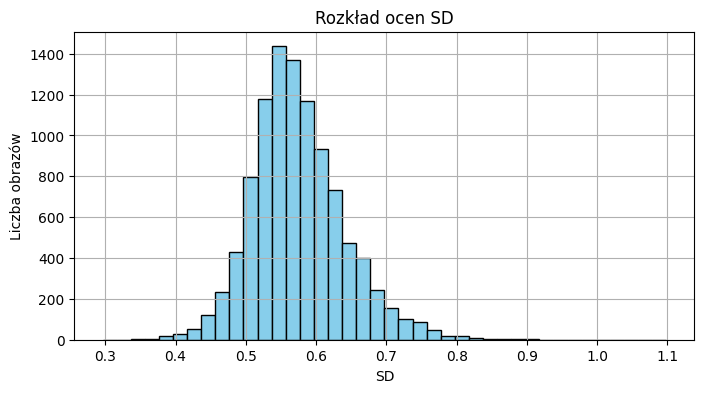

In [41]:
plt.figure(figsize=(8, 4))
df["SD"].hist(bins=40, color="skyblue", edgecolor="black")
plt.title("Rozkład ocen SD")
plt.xlabel("SD")
plt.ylabel("Liczba obrazów")
plt.grid(True)
plt.show()

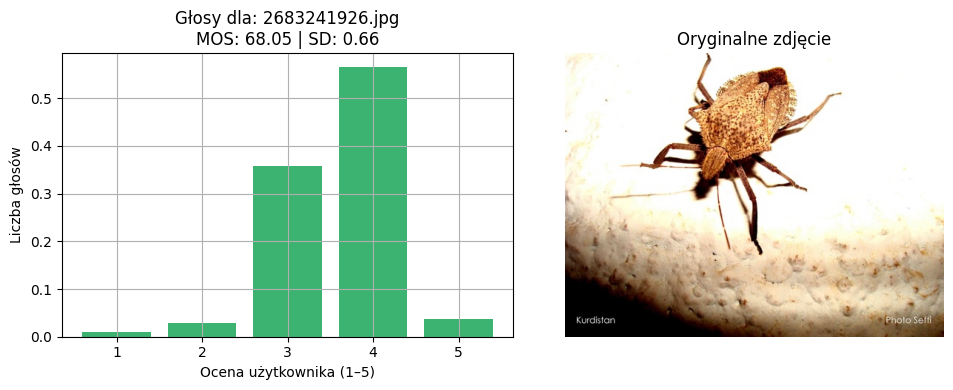

In [48]:
idx = random.randint(0, len(df) - 1)
row = df.iloc[idx]
votes = [row[f"c{i}"] for i in range(1, 6)]
img_path = row["path"]

# Wczytaj obraz w oryginalnej postaci
img = Image.open(img_path).convert("RGB")

# Tworzymy układ 1x2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# 🔹 Wykres słupkowy
ax1.bar(range(1, 6), votes, color="mediumseagreen")
ax1.set_title(f"Głosy dla: {row['image_name']}\nMOS: {row['MOS']:.2f} | SD: {row['SD']:.2f}")
ax1.set_xlabel("Ocena użytkownika (1–5)")
ax1.set_ylabel("Liczba głosów")
ax1.set_xticks(range(1, 6))
ax1.grid(True)

# 🔹 Miniaturka obrazu (oryginał)
ax2.imshow(img)
ax2.set_title("Oryginalne zdjęcie")
ax2.axis("off")

plt.tight_layout()
plt.show()